In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


Main.Src

In [2]:
using Plots, JLD2,.Src

In [3]:
N = 5000
t_end = 100.0
t_fixed = true
M = 1000
path = "C:/Users/lisah/Documents/Repos/ma-code/temp_saves"

"C:/Users/lisah/Documents/Repos/ma-code/temp_saves"

# Visualisation of Sobol indices

## Region 1

In [ ]:
@load "$path/r1/sobol_n_$(N)_$(t_end)_$M.jld2" sobol_n
@load "$path/r1/sobol_w_$(N)_$(t_end)_$M.jld2" sobol_w;

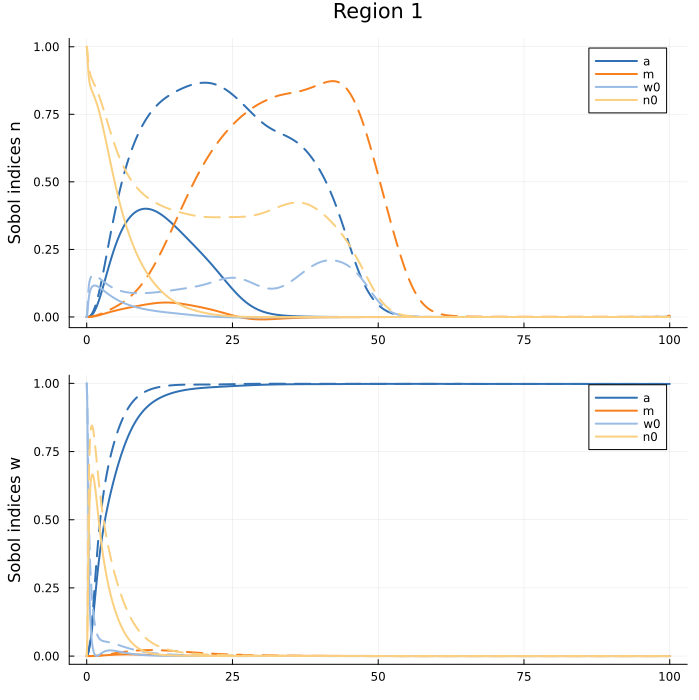

In [15]:
sobol_index_subplot_wn(sobol_n, sobol_w, title="Region 1")

Interpretation:
- system always converges to stable state. Indices in w,n compartment indicate maximal time needed for convergence. Once convergence is reached, very little variance in n comparment (see pi left of bifurcation point). Point it converges to (i.e. 0) does not depend on input parameters.
- n0 matters until convergence is reached
- value in stable state: w=a, thus a sensitive in w compartment -> observation of w trajectory enables to infer a value.
- n compartment: 
- large parameter interactions present in n compartment: sensitivity arises mostly due to interactions between a,m,n0

## Region 2

In [ ]:
@load "$path/r2/sobol_n_$(N)_$(t_end)_$M.jld2" sobol_n
@load "$path/r2/sobol_w_$(N)_$(t_end)_$M.jld2" sobol_w;

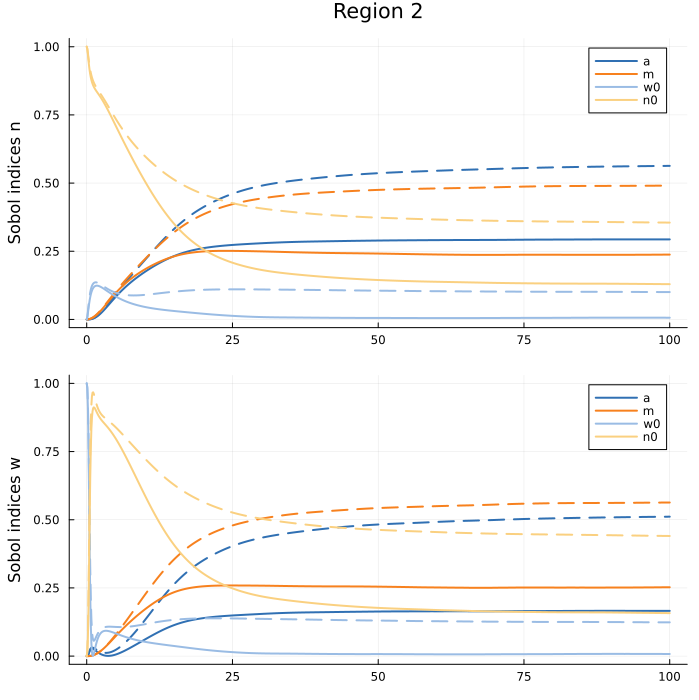

In [13]:
sobol_index_subplot_wn(sobol_n, sobol_w, title="Region 2")

Interpretation:
- in general high sensitivity, because we have alterante convergence to different eq.pts.
- a,m decide location of bif. pt. -> high influence on to which eq.pt. system converges, because if e.g. eq. lies at sampling border, we converge to pf. eq. independently on inits.
- convergence behaviour is mainly decided by bif. pt. and in w compartment m has more influence on bifurcation location than a. In n comparment both have same influence on bifurcation location, however sampling range of a is larger, which might be why it appears more sensitive
- n0 more sensitive than w0 indicates that biomass trajectories show greater variability when simulating the model, and independently of initial condition course of w is less variable than the course of n (this is also later verified by forward uq)

what can i do?
- fix m and assess sensitivity
- fix n0

## Region 3

In [ ]:
@load "$path/r3/sobol_n_$(N)_$(t_end)_$M.jld2" sobol_n
@load "$path/r3/sobol_w_$(N)_$(t_end)_$M.jld2" sobol_w;

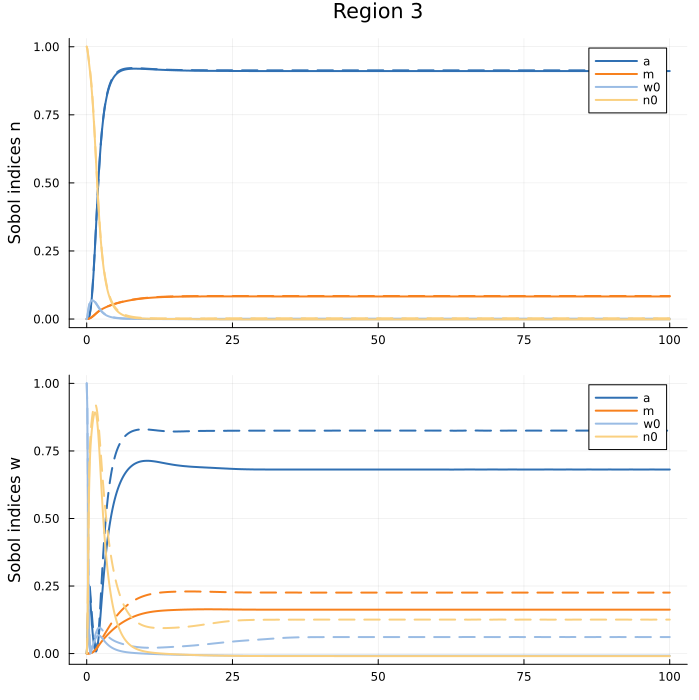

In [11]:
sobol_index_subplot_wn(sobol_n, sobol_w, title="Region 3")

Interpretation:
- w comparment: value of w depends on a, which is why a is sensitive, but also on m, because m shifts bifurcation branch as well
- n comparment: value of n depends heavily on a (value system converges to), but also a little on m, as m shifts the bifurcation curve significantly.

## Region 4

In [8]:
@load "$path/dr/sobol_n_$(N)_$(t_end)_$(M)_pf.jld2" sobol_n
@load "$path/dr/sobol_w_$(N)_$(t_end)_$(M)_pf.jld2" sobol_w;

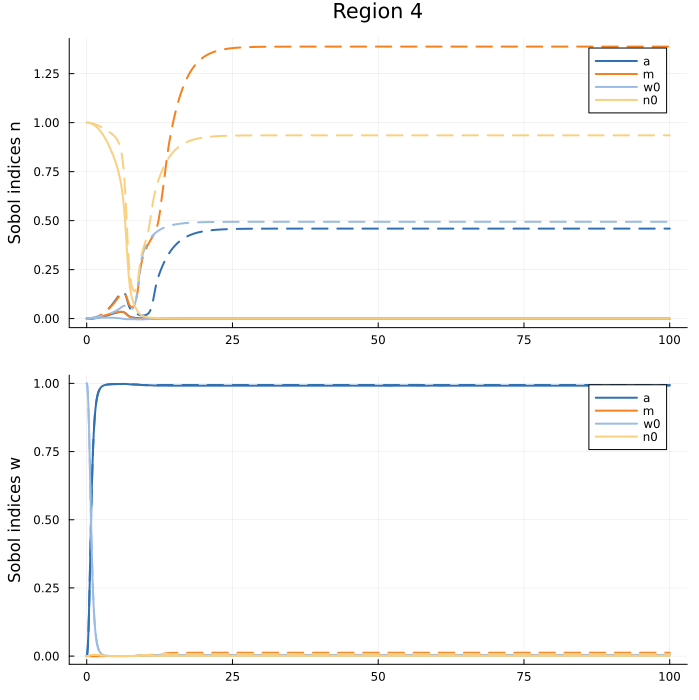

In [9]:
sobol_index_subplot_wn(sobol_n, sobol_w, title="Region 4")

Interpretation:
- w compartment: same interpretation as in case left of bifurcation
- n comparment: converges faster than in case 1.
- very fast convergence, because system starts near equlibria -> can be seen in n comparment,e.g. n0 trajectory.
- it seems like after convergence is reached, parameter interactions appear.
-> maybe pick one point there in inverse UQ procedure
